In [118]:
# Imbalanced dataset
is_fraud = train_transaction[train_transaction["isFraud"] == 1]
not_fraud = train_transaction[train_transaction["isFraud"] == 0]

# Random under-sampling
length_isfraud = len(is_fraud)
notfraud_undersample = not_fraud.sample(length_isfraud)

train_transaction_undersampled = pd.concat([is_fraud, notfraud_undersample], axis=0)
X_train_undersampled = train_transaction_undersampled.drop("isFraud", axis=1)
y_train_undersampled = train_transaction_undersampled["isFraud"]

203       1
240       1
243       1
245       1
288       1
         ..
185098    0
495101    0
563472    0
262674    0
130754    0
Name: isFraud, Length: 41326, dtype: category
Categories (2, int64): [0, 1]


In [49]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
%matplotlib inline

In [11]:
%pip install seaborn plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\lzyda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [71]:
train_transaction = pd.read_csv('./data/raw/train_transaction.csv')
train_identity = pd.read_csv('./data/raw/train_identity.csv')
test_transaction = pd.read_csv('./data/raw/test_transaction.csv')
test_identity = pd.read_csv('./data/raw/test_identity.csv')

In [73]:
train_transaction = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [98]:
train_transaction.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


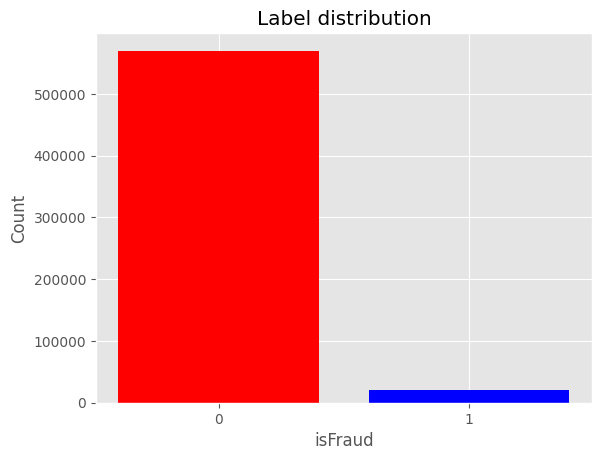

NameError: name 'pri' is not defined

In [123]:
X_train = train_transaction.drop("isFraud", axis=1)
train_transaction["isFraud"] = train_transaction["isFraud"].astype("category")
y_train = train_transaction["isFraud"]



isfraud, count = np.unique(y_train, return_counts=True)
plt.bar(isfraud, count, color=["red", "blue"], tick_label=isfraud)
plt.title("Label distribution")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show

This graph suggests that a significant number of transactions are non fradulent, and only a small % of them are fradulent (as one would expect). It should be noted that this dataset is extremely uneven, and to keep this into consideration when we develop our models. We can either perform under or over sampling techniques, or use other metrics such as a precision, recall, and AUC instead of simply accuracy.

In [64]:
print(train_transaction["TransactionDT"].head(10))
print(train_transaction["M2"].head(10))

0    86400
1    86401
2    86469
3    86499
4    86506
5    86510
6    86522
7    86529
8    86535
9    86536
Name: TransactionDT, dtype: int64
0      T
1    NaN
2      T
3    NaN
4    NaN
5      T
6      T
7    NaN
8    NaN
9      T
Name: M2, dtype: object


In [68]:
display(train_identity.head())

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
print(train_transaction.columns)

In [34]:
train_transaction['D1n'] =  train_transaction['D1'] -   train_transaction.TransactionDT/np.float32(24*60*60)

In [36]:
#Can remove columns with 90% missing values

def top_missing_cols(df,n=10,thresh=90):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [37]:
top_missing_cols(train_transaction, thresh=90)

There are 416 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


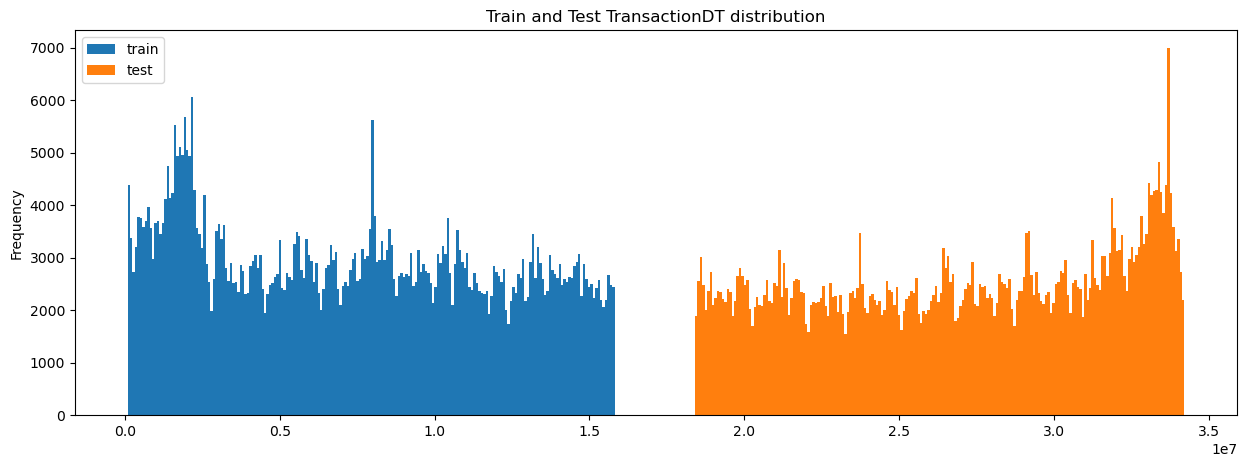

In [38]:
train_transaction['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist', label='test', bins=200)
plt.legend()
plt.show()

As TransactionDT is defined as the time delta of the transaction, we can deduce that the training and test datasets are split by time. This may potentially impact any cross validation techniques.

<AxesSubplot: title={'center': 'Test Log Transaction Amt'}, ylabel='Frequency'>

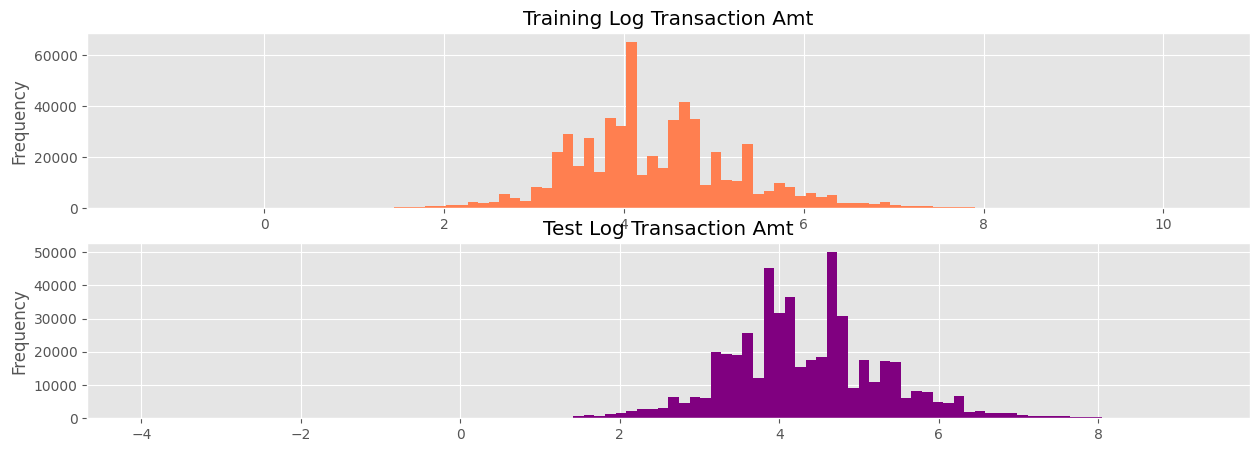

In [142]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 6))
train_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Training Log Transaction Amt',
              color='coral',
              ax=ax1)

test_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Test Log Transaction Amt',
              color='purple',
              ax=ax2)

KeyError: 'isFraud'

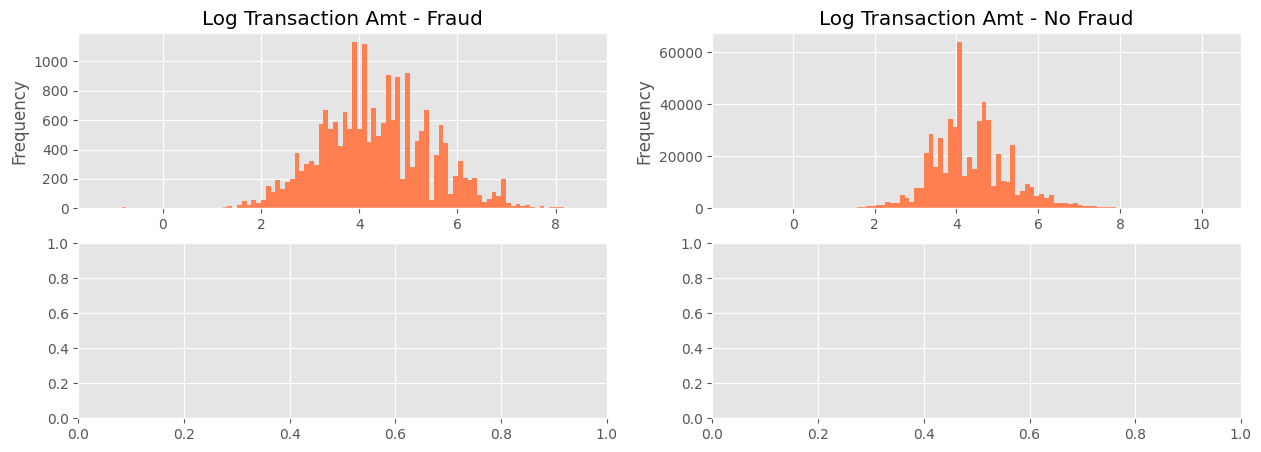

In [144]:
# now we split by fraud and no fraud
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='Fraud', 
              bins=100, 
              title='Log Transaction Amt - Fraud',
              color='coral',
              ax=ax1)

train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='No Fraud', 
              bins=100, 
              title='Log Transaction Amt - No Fraud',
              color='coral',
              ax=ax2)

test_transaction[test_transaction['isFraud'] == 1]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='Fraud', 
              bins=100, 
              title='Log Transaction Amt - Fraud',
              color='purple',
              ax=ax3)

test_transaction[test_transaction['isFraud'] == 0]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='No Fraud', 
              bins=100, 
              title='Log Transaction Amt - No Fraud',
              color='purple',
              ax=ax4)

<Axes: title={'center': 'Test TransactionAmt distribution'}, ylabel='Frequency'>

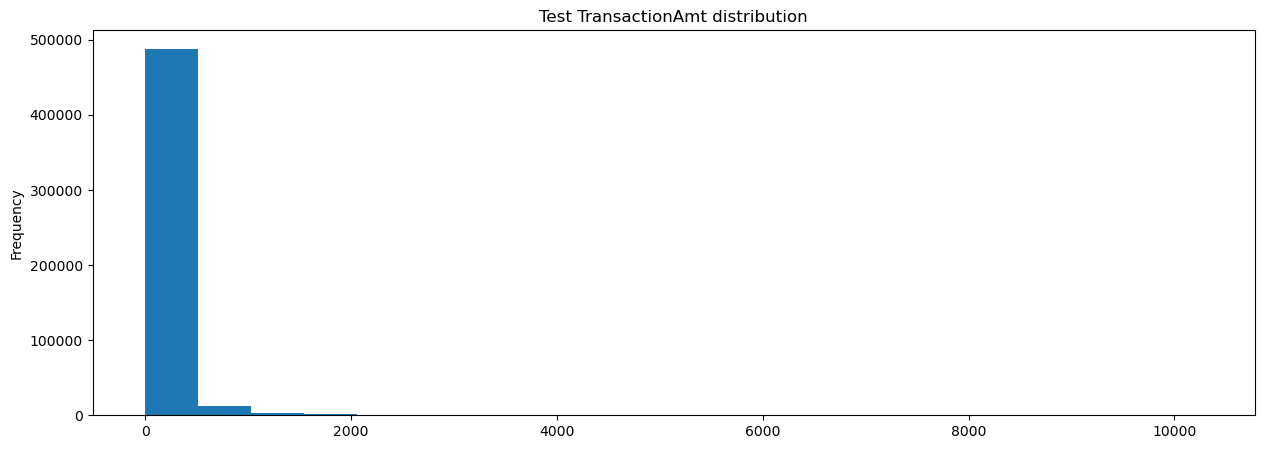

In [40]:
test_transaction['TransactionAmt'].plot(kind='hist', figsize=(15, 5), label='test', bins=20, title='Test TransactionAmt distribution')

In [114]:
Ds = ["D" + str(x) for x in range(1,16)]
Ds.append("TransactionDT")
# print(Ds)
train_transaction[Ds]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,TransactionDT
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,86400
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,86401
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,86469
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,86499
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,15811047
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811049
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811079
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,15811088


In [95]:
train_transaction['D1'] - train_transaction.TransactionDT/np.float32(24*60*60)

0          13.000000
1          -1.000012
2          -1.000799
3         110.998854
4          -1.001227
             ...    
590535   -153.998229
590536   -182.998252
590537   -182.998600
590538   -160.998704
590539   -182.999201
Length: 590540, dtype: float64

In [61]:
def high_correlation(df, col_start, col_end, threshold):
    corr = df.loc[:, col_start:col_end].corr()
    # print(corr[corr>0.9])
    # if > threshold: suggest remove
    cols = corr.columns
    res = set()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if corr.iloc[i, j] > threshold:
                res.add(cols[j])
    return res

subsets = [("C1", "C14"), ("D1, D15"), ("M1", "M9"), ("V1", "V339")]
for subset in subsets:
    print(high_correlation(train_transaction, subset[0], subset[1], 0.9))

{'D12', 'D2', 'D6', 'D7'}

In [127]:
print(train_transaction.columns.tolist())

['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 

In [143]:
'''
Hypothesis: To identify users, possible features to use: 
"card1": "card6", 
"addr1", "addr2",
P_emaildomain
R_emaildomain
'''
train_transaction.loc[:, "M1":"M9"]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


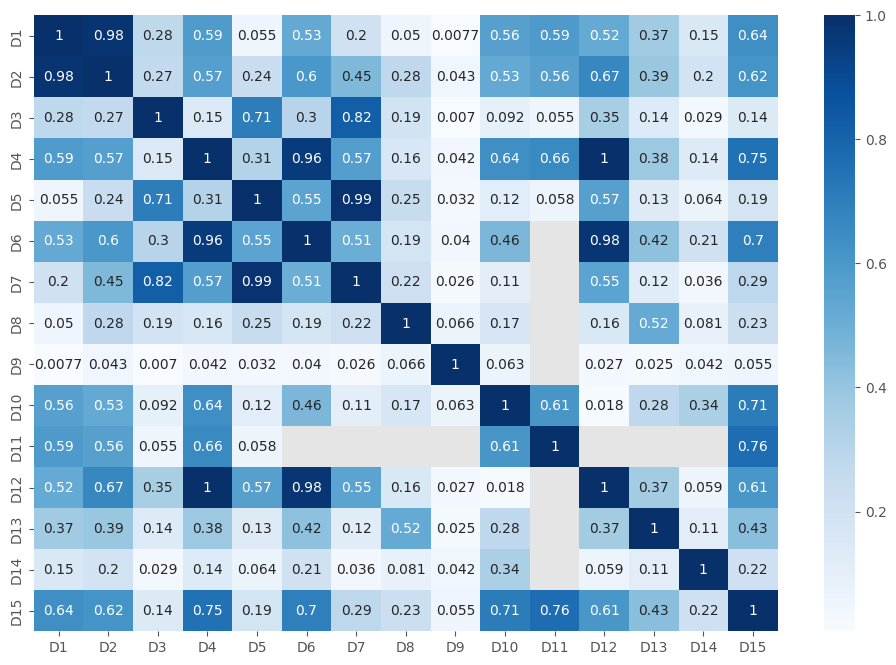

In [60]:
%matplotlib inline
corr = train_transaction.loc[:, "D1":"D15"].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [47]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


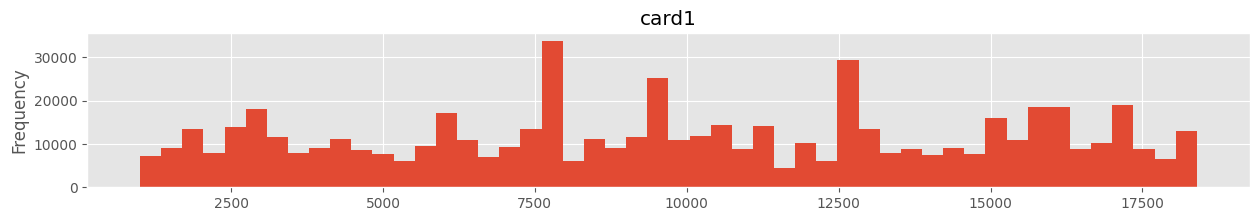

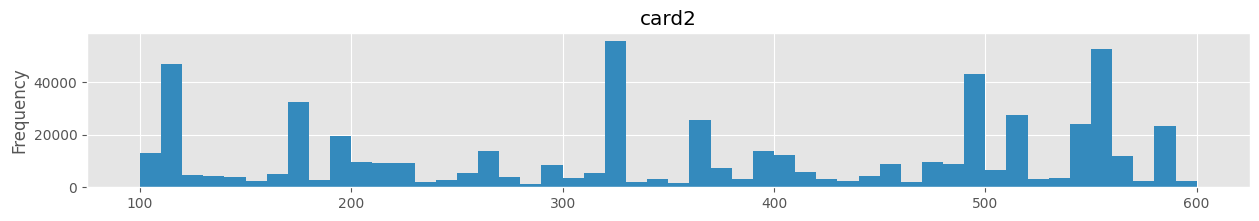

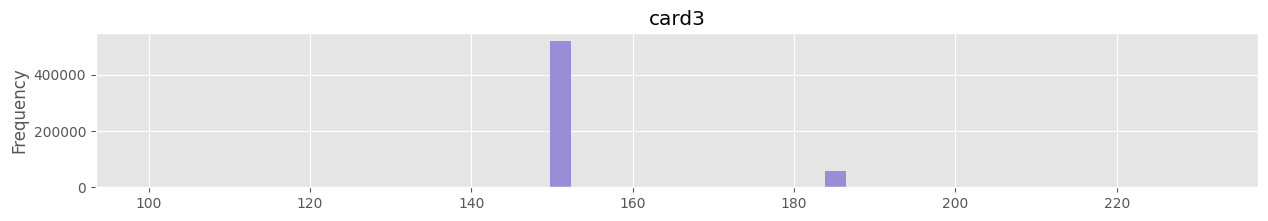

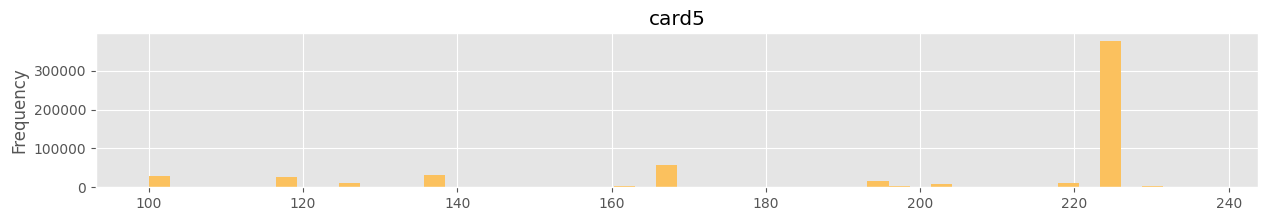

In [50]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train_transaction['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Transaction Amounts Quantiles:
0.010       9.2440
0.025      14.5010
0.100      25.9500
0.250      43.3210
0.500      68.7690
0.750     125.0000
0.900     275.2930
0.975     648.3345
0.990    1104.0000
Name: TransactionAmt, dtype: float64


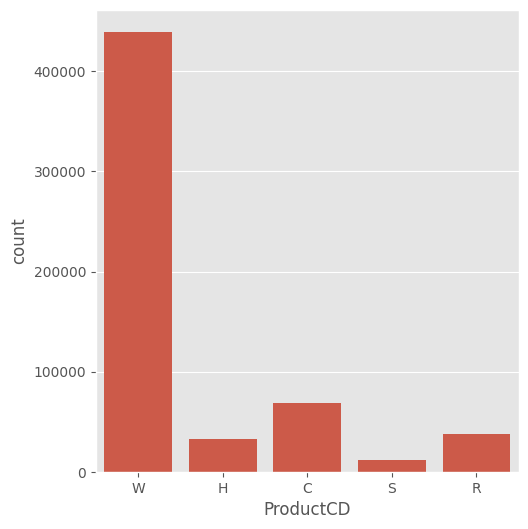

In [122]:
plt.figure(figsize=(12,6))
plt.subplot(121)
g = sns.countplot(x='ProductCD', data =train_transaction)
